In [1]:
!pip install tensorflow==1.15
!pip install "tensorflow_hub>=0.6.0"
!pip3 install tensorflow_text==1.15

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#load data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.python.keras.backend as K

'''
build a custom layer using Keras, integrating BERT from tf-hub,
we could also fine tune the BERT model, for example: only subset of pre-trained BERT layers
'''
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, n_fine_tune_layer=12, bert_path='https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1', **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layer
        self.trainable = True
        self.output_size = 768
        self.bert_path = bert_path
        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(self.bert_path, trainable=self.trainable, name="{}_module".format(self.name))
        trainable_vars = self.bert.variables
        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers:]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
        # Add non_trainable weights:
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs] #cast the variables to int32 tensor
        input_ids, input_mask, segment_ids, valid_positions = inputs
        ## we don't feed the valid_position into the model, the valid_position is only used for the slots transform to align to the tokenized input
        bert_inputs = dict(input_ids=input_ids, ## we can use 'convert_tokens_to_ids' function to get the ids from tokens
                           input_mask=input_mask,
                           segment_ids=segment_ids)
        result = self.bert(inputs=bert_inputs, signature='tokens', as_dict=True)
        return result['pooled_output'], result['sequence_output']

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.output_size)


In [5]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

class NLUModel:

    def __init__(self):
        self.model = None

    def visualize_metric(self, history_dic, metric_name):
        plt.plot(history_dic[metric_name])
        legend = ['train']
        if 'val_' + metric_name in history_dic:
            plt.plot(history_dic['val_'+metric_name])
            legend.append('test')
        plt.title('model_' + metric_name)
        plt.ylabel(metric_name)
        plt.xlabel('epoch')
        plt.legend(legend, loc='upper left')
        plt.show()

    def predict(self, x):
        return self.model.predict(x)

    def save(self, model_path):
        self.model.save(model_path)

    def load(model_path, custom_objects=None):
        new_model = NLUModel()
        new_model.model = load_model(model_path, custom_objects=custom_objects)
        return new_model

    def predict_slots_intent(self, x, slots_tokenizer, intents_label_encoder):
        if len(x.shape) == 1:
            x = x[np.newaxis, ...]

        y1, y2 = self.predict(x)
        intents = np.array([intents_label_encoder.inverse_transform([np.argmax(y2[i])])[0] for i in range(y2.shape[0])])
        slots = []
        for i in range(y1.shape[0]):
            y = [np.argmax(i) for i in y1[i]]
            slot = []
            for i in y:
                if i == 0:
                  pass
        
                else:
                    slot.append(slots_tokenizer.index_word[i])
            slots.append(slot[:len(x[i])+1])
        return intents, slots

In [6]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

'''
By using LabelEncoder to create the labelencoder of slot-tags
'''
class TagsVectorizer:

    def __init__(self):
        pass

    def tokenize(self, tags_str_arr):
        return [s.split() for s in tags_str_arr]

    def fit(self, train_tags_str_arr, val_tags_str_arr):
        ## in order to avoid, in valid_dataset, there is tags which not exit in train_dataset. like: ATIS datset
        self.label_encoder = LabelEncoder()
        data = ["[padding]", "[CLS]", "[SEP]"] + [item for sublist in self.tokenize(train_tags_str_arr) for item in sublist]
        data = data + [item for sublist in self.tokenize(val_tags_str_arr) for item in sublist]
        ## # data:  ["[padding]", "[CLS]", "[SEP]", all of the real tags]; add the "[padding]", "[CLS]", "[SEP]" for the real tag list
        self.label_encoder.fit(data)

    def transform(self, tags_str_arr, valid_positions):
        ## if we set the maximum length is 50, then the seq_length is 50; otherwise, it will be equal to the maximal length of dataset
        seq_length = valid_positions.shape[1] # .shape[0]: number of rows, .shape[1]: number of columns
        data = self.tokenize(tags_str_arr)
        ## we added the 'CLS' and 'SEP' token as the first and last token for every sentence respectively
        data = [self.label_encoder.transform(["[CLS]"] + x + ["[SEP]"]).astype(np.int32) for x in data] #upper 'O', not 0
        data=np.array(data)
        #print(data)
        output = np.zeros((len(data), seq_length))
        #print(output)
        print(valid_positions)
        for i in range(len(data)):
            idx = 0
            for j in range(seq_length):
                if valid_positions[i][j] == 1:
                  if idx>=len(data[i]):
                    output[i][j]=0
                  else:
                    output[i][j] = data[i][idx]
                    idx += 1
        return output

    def inverse_transform(self, model_output_3d, valid_position):
        ## model_output_3d is the predicted slots output of trained model
        seq_length = valid_position.shape[1]
        slots = np.argmax(model_output_3d, axis=-1)
        slots = [self.label_encoder.inverse_transform(y) for y in slots]
        output = []
        for i in range(len(slots)):
            y = []
            for j in range(seq_length):
                if valid_position[i][j] == 1:
                  y.append(str(slots[i][j]))
                    
            output.append(y)
        
        return output

    def load(self):
        pass

    def save(self):
        pass

if __name__ == '__main__':
    train_tags_str_arr = ['O O B-X B-Y', 'O B-Y O']
    val_tags_str_arr = ['O O B-X B-Y', 'O B-Y O XXX']
    valid_positions = np.array([[1, 1, 1, 1, 0, 1, 1], [1, 1, 0, 1, 1, 0, 1]])

    vectorizer = TagsVectorizer()
    vectorizer.fit(train_tags_str_arr, val_tags_str_arr)
    data = vectorizer.transform(train_tags_str_arr, valid_positions)
    print(data, vectorizer.label_encoder.classes_)

[[1 1 1 1 0 1 1]
 [1 1 0 1 1 0 1]]
[[4. 2. 2. 0. 0. 1. 5.]
 [4. 2. 0. 1. 2. 0. 5.]] ['B-X' 'B-Y' 'O' 'XXX' '[CLS]' '[SEP]' '[padding]']


In [7]:
!pip install bert-tensorflow

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from bert.tokenization import FullTokenizer

'''
import the BERT model from tensorflow_hub library and create the tokenizer to pre-process the dataset,
and to tokenize every word and get the corresponding input_ids, input_mask, segment_ids and valid_positions of every sentence
'''
class BERTVectorizer:

    def __init__(self, sess, bert_model_hub_path):
        self.sess = sess
        self.bert_model_hub_path = bert_model_hub_path
        self.create_tokenizer_from_hub_module()
        #print(bert_model_hub_path)

    def create_tokenizer_from_hub_module(self):
        # get the vocabulary and lowercasing or uppercase information directly from the BERT tf hub module
        bert_module = hub.Module(self.bert_model_hub_path)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        vocab_file, do_lower_case = self.sess.run(
            [
                tokenization_info["vocab_file"],
                tokenization_info["do_lower_case"]
            ]
        )
        self.tokenizer = FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case) #do_lower_case=True
        # print(tokenizer.tokenize('hello world!'))  --> ['hello', 'world', '!']

    def tokenize(self, text:str): ## tokenize every sentence
        words = text.split()
        ## # text: add leah kauffman to my uncharted 4 nathan drake playlist
        ## # words: ['add', 'leah', 'kauffman', 'to', 'my', 'uncharted', '4', 'nathan', 'drake', 'playlist']
        tokens = []
        ## # tokens: ['add', 'leah', 'ka', '##uf', '##fm', '##an', 'to', 'my', 'un', '##cha', '##rted', '4', 'nathan', 'drake', 'play', '##list']
        valid_positions = []
        ## # valid_positions:[1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]
        for i, word in enumerate(words):
            token = self.tokenizer.tokenize(word)
            tokens.extend(token)
            for i in range(len(token)):
                if i == 0:
                    valid_positions.append(1)
                else:
                    valid_positions.append(0)
        #print(tokens)
        #print(tokens)
        return tokens, valid_positions

    def transform(self, text_arr):
        input_ids = []
        input_mask = []
        segment_ids = []
        valid_positions = []
        for text in text_arr:
            ids, mask, seg_ids, valid_pos = self.__vectorize(text)
            input_ids.append(ids)
            input_mask.append(mask)
            segment_ids.append(seg_ids)
            valid_positions.append(valid_pos)

        sequence_length = np.array([len(i) for i in input_ids])

        ## set the maximum length is 50
        input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=50, truncating='post', padding='post')
        input_mask = tf.keras.preprocessing.sequence.pad_sequences(input_mask, maxlen=50, truncating='post', padding='post')
        segment_ids = tf.keras.preprocessing.sequence.pad_sequences(segment_ids, maxlen=50, truncating='post', padding='post')
        valid_positions = tf.keras.preprocessing.sequence.pad_sequences(valid_positions, maxlen=50, truncating='post', padding='post')

        # input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, padding='post')
        # input_mask = tf.keras.preprocessing.sequence.pad_sequences(input_mask, padding='post')
        # segment_ids = tf.keras.preprocessing.sequence.pad_sequences(segment_ids, padding='post')
        # valid_positions = tf.keras.preprocessing.sequence.pad_sequences(valid_positions, padding='post')

        return input_ids, input_mask, segment_ids, valid_positions, sequence_length

    def __vectorize(self, text:str):
        tokens, valid_positions = self.tokenize(text)

        ## insert the first token "[CLS]"
        tokens.insert(0, '[CLS]')
        valid_positions.insert(0, 1)
        ## insert the last token "[SEP]"
        tokens.append('[SEP]')
        valid_positions.append(1)
        ## ['[CLS]', 'add', 'leah', 'ka', '##uf', '##fm', '##an', 'to', 'my', 'un', '##cha', '##rted', '4', 'nathan', 'drake', 'play', '##list', '[SEP]']
        ## [1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]

        '''
        (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0     0   0   0  0     0 0
        
        Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        '''
        segment_ids = [0] * len(tokens)
        ## # segment_ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        ## # input_ids: [101, 5587, 14188, 10556, 16093, 16715, 2319, 2000, 2026, 4895, 7507, 17724, 1018, 7150, 7867, 2377, 9863, 102] and the first is always 101 and the last is 102

        input_mask = [1] * len(input_ids) ## The mask has 1 for real tokens and 0 for padding tokens.
        ## # input_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

        return input_ids, input_mask, segment_ids, valid_positions

In [10]:
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Multiply, TimeDistributed, Dropout
import numpy as np
import os
import json

'''
build and compile our model using the BERT layer
'''
class JointBertModel(NLUModel):
    def __init__(self, slots_num, intents_num, sess, num_bert_fine_tune_layers=12):
        self.slots_num = slots_num
        self.intents_num = intents_num
        self.num_bert_fine_tune_layers = num_bert_fine_tune_layers

        self.model_params = {
            'slots_num': slots_num,
            'intents_num': intents_num,
            'num_bert_fine_tune_layers': num_bert_fine_tune_layers
        }

        self.build_model()
        self.compile_model()

        self.initialize_vars(sess)


    def build_model(self):

        in_id = Input(shape=(None,), name='input_ids')
        in_mask = Input(shape=(None,), name='input_masks')
        in_segment = Input(shape=(None,), name='segment_ids')
        in_valid_positions = Input(shape=(None, self.slots_num), name='valid_positions')
        bert_inputs = [in_id, in_mask, in_segment, in_valid_positions]

        # the output of trained Bert
        bert_pooled_output, bert_sequence_output = BertLayer(n_fine_tune_layer=self.num_bert_fine_tune_layers, name='BertLayer')(bert_inputs)

        # add the additional layer for intent classification and slot filling
        intents_drop = Dropout(rate=0.1)(bert_pooled_output)
        intents_fc = Dense(self.intents_num, activation='softmax', name='intent_classifier')(intents_drop)

        slots_drop = Dropout(rate=0.1)(bert_sequence_output)
        slots_output = TimeDistributed(Dense(self.slots_num, activation='softmax'))(slots_drop)
        slots_output = Multiply(name='slots_tagger')([slots_output, in_valid_positions])

        self.model = Model(inputs=bert_inputs, outputs=[slots_output, intents_fc])

    def compile_model(self):
        optimizer = tf.keras.optimizers.Adam(lr=5e-5)
        # if the targets are one-hot labels, using 'categorical_crossentropy'; while if targets are integers, using 'sparse_categorical_crossentropy'
        losses = {
            'slots_tagger': 'sparse_categorical_crossentropy',
            'intent_classifier': 'sparse_categorical_crossentropy'
        }
        ## loss_weights: to weight the loss contributions of different model outputs.
        loss_weights = {'slots_tagger': 3.0, 'intent_classifier': 1.0}
        metrics = {'intent_classifier': 'acc'}
        self.model.compile(optimizer=optimizer, loss=losses, loss_weights=loss_weights, metrics=metrics)
        self.model.summary()

    def fit(self, X, Y, validation_data=None, epochs=5, batch_size=32):
        X = (X[0], X[1], X[2], self.prepare_valid_positions(X[3]))
        if validation_data is not None:
            X_val, Y_val = validation_data
            validation_data = ((X_val[0], X_val[1], X_val[2], self.prepare_valid_positions(X_val[3])), Y_val)

        history = self.model.fit(X, Y, validation_data=validation_data, epochs=epochs, batch_size=batch_size)

        self.visualize_metric(history.history, 'slots_tagger_loss')
        self.visualize_metric(history.history, 'intent_classifier_loss')
        self.visualize_metric(history.history, 'loss')
        self.visualize_metric(history.history, 'intent_classifier_acc')
        

    def prepare_valid_positions(self, in_valid_positions):
        ## the input is 2-D in_valid_position
        in_valid_positions = np.expand_dims(in_valid_positions, axis=2) ## expand the shape of the array to axis=2
        ## 3-D in_valid_position
        in_valid_positions = np.tile(in_valid_positions, (1,1,self.slots_num)) ##
        return in_valid_positions

    def predict_slots_intent(self, x, slots_vectorizer, intent_vectorizer, remove_start_end=True):
        valid_positions = x[3]
        x = (x[0], x[1], x[2], self.prepare_valid_positions(valid_positions))

        y_slots, y_intent = self.predict(x)

        ### get the real slot-tags using 'inverse_transform' of slots-vectorizer
        slots = slots_vectorizer.inverse_transform(y_slots, valid_positions)
        if remove_start_end: ## remove the first '[CLS]' and the last '[SEP]' tokens.
            slots = np.array([x[1:-1] for x in slots])
            
        ### get the real intents using 'inverse-transform' of intents-vectorizer
        intents = np.array([intent_vectorizer.inverse_transform([np.argmax(y_intent[i])])[0] for i in range(y_intent.shape[0])])
        return slots, intents

    def initialize_vars(self, sess):
        sess.run(tf.compat.v1.local_variables_initializer())
        sess.run(tf.compat.v1.global_variables_initializer())
        K.set_session(sess)

    def save(self, model_path):
        with open(os.path.join(model_path, 'params.json'), 'w') as json_file:
            json.dump(self.model_params, json_file)
        self.model.save_weights(os.path.join(model_path, 'joint_bert_model.h5'))

    def load(load_folder_path, sess):
        with open(os.path.join(load_folder_path, 'params.json'), 'r') as json_file:
            model_params = json.load(json_file)

        slots_num = model_params['slots_num']
        intents_num = model_params['intents_num']
        num_bert_fine_tune_layers = model_params['num_bert_fine_tune_layers']

        new_model = JointBertModel(slots_num, intents_num, sess, num_bert_fine_tune_layers)
        new_model.model.load_weights(os.path.join(load_folder_path, 'joint_bert_model.h5'))
        return new_model


In [11]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [13]:
import os

class Reader:
    def __init__(self):
        pass

    def read(dataset_folder_path):
        wb = gc.open_by_url(dataset_folder_path)
        sheet=wb.sheet1
        data = sheet.get_all_values()
        df = pd.DataFrame(data)
        df.columns = df.iloc[0]
        new_data=df.to_numpy()
        text_arr=new_data[1:,0]
        text_arr_new=[]
        tag_arr=new_data[1:,2]
        tag_arr_new=[]
        label_arr=new_data[1:,1]
        label_arr_new=[]
        a_action_arr=new_data[1:,6]
        a_action_arr_new2=[]
        for i in range(0,len(tag_arr)):
          if len(tag_arr[i])>3:
            text_arr_new.append(text_arr[i])
            tag_arr_new.append(tag_arr[i])
            label_arr_new.append(label_arr[i])
            a_action_arr_new2.append(a_action_arr[i])
        print(len(text_arr_new))
        print(len(tag_arr_new))
        print(len(label_arr_new))
        print(len(a_action_arr_new2))
        count=0;

        # with open(os.path.join(dataset_folder_path, 'label'), encoding='utf-8') as f:
        #     labels = f.readlines()

        # with open(os.path.join(dataset_folder_path, 'seq.in'), encoding='utf-8') as f:
        #     text_arr = f.readlines()

        # with open(os.path.join(dataset_folder_path, 'seq.out'), encoding='utf-8') as f:
        #     tags_arr = f.readlines()

        # assert len(text_arr) == len(tags_arr) == len(labels) # test by using 'assert'
        
        # ext_arr_new=np.array(text_arr_new)
        # tag_arr_new=np.array(tag_arr_new)
        # label_arr_new=np.array(label_arr_new)
        n1=None
        n2=None
        n3=None
        n4=None
        n4=a_action_arr_new2
        n1=text_arr_new
        n2=tag_arr_new
        n3=label_arr_new
        return n1,n2,n3,n4

if __name__ == '__main__':
      text_arr_new,tag_arr_new,label_arr_new,a_action_arr_new=Reader.read('https://docs.google.com/spreadsheets/d/1hqpyPcAIY-P9hoChU69SXLRGfhuKFGmQE4vvcp9RSdU/edit#gid=0') #link of dataset of google sheet
      print(text_arr_new, tag_arr_new, label_arr_new,a_action_arr_new)

8357
8357
8357
8357
['hi, can you help me in buying a phone ?', 'it should have good camera and good battery capacity', 'how much does it cost ? ', "what is it's color ? ", 'oh, is it possible in black ? ', 'but I like black', "what is it's cost ? ", 'ok can you book Redmi A for me', 'Thanks for help', 'hi, I want to buy a new phone', 'It should have OS android and dual sim features', 'what is its cost ?', 'what color is it ?', 'Oh, is it possible to get in white color ?', 'but I would prefer in white', "what's the price ?", 'Okay, I will book Oppo AA model', 'Thanks a lot ', 'Hey, I am looking for a good phone', 'It should be touch phone with good memory and high camera quality', 'What is the price ?', 'Does it has DualSim ?', 'Is it new released phone ?', 'What is its OS ?', 'Oh it is not good for me. I want Android Operating phone', 'But I am comfortable with Android Operating phone', 'What is the cost ?', 'ok can you book Oppo AA  for me', 'Thanks for help', 'Hey, can you help me i

In [14]:
print(tag_arr_new[0])

O O O O O O O O O O


In [15]:
tag_arr_new=np.array(tag_arr_new)
tag_arr_new2=[]
for i in range(len(tag_arr_new)):
  #print(tag_arr_new[i])
  if tag_arr_new[i]=='null':
    tag=''
    for k in range(len(text_arr_new[i].split())):
      tag=tag+' '+'O'
    tag_arr_new2.append(tag)
  else:
    tag_arr_new2.append(tag_arr_new[i])

In [16]:
print(tag_arr_new2)

['O O O O O O O O O O', 'O O O B-Camera O O B-Battery O O ', 'O O O O O O', 'O O O O O', 'O O O O O B-Color O', 'O O O O', 'O O O O O', 'O O O O O O O O ', 'O O O', 'O O O O O O O O', 'O O O O B-OS O  B-Dualsim O O', 'O O O O O', 'O O O O O', 'O O O O O O O B-Color O O', 'O O O O O O', 'O O O O', 'O O O O O O O', 'O O O', 'O O O O O O O O ', 'O O O B-Touch O O B-Memory O O B-Camera O O', 'O O O O O', 'O O O O O', 'O O O O O O', 'O O O O O', 'O O O O O O O O O B-OS O O', 'O O O O O B-OS O O', 'O O O O O', 'O O O O O O O O ', 'O O O', 'O O O O O O O O O O O', 'O O O O O B-Color O O O B-Memory O O', 'O O O O O O', 'O O O O O O O O ', 'O O O O O O O O ', 'O O O O O', 'O O O O O O O O O O O O O O B-Cost O O', 'O O O O O O O O', 'O O O O O O O O', 'O O O O O O', 'O O O O O O O O', 'O O O O O O O B-Camera O O O B-Rating O', 'O O O O O', 'O O O O O', 'O O O O O O', 'O O O O O', 'O O O O O O O O O O O B-Cost O', 'O O O O', 'O O O O O', 'O O O O O O O O', 'O O O O O O', 'O O O O O O', 'O O O O O

In [17]:
for i in range(len(tag_arr_new2)-1):
  text_arr_new[i+1]=text_arr_new[i+1]+' '
  text_arr_new[i+1]=text_arr_new[i+1]+label_arr_new[i]
  text_arr_new[i+1]=text_arr_new[i+1]+' '
  text_arr_new[i+1]=text_arr_new[i+1]+a_action_arr_new[i]
  tag_arr_new2[i+1]=tag_arr_new2[i+1]+' O O'

In [18]:
train_text_arr=[]
train_tags_arr=[]
train_intents=[]
for i in range(0,5000):
  train_text_arr.append(text_arr_new[i])
  train_tags_arr.append(tag_arr_new2[i])
  train_intents.append(label_arr_new[i])
print(len(train_text_arr),len(train_tags_arr),len(train_intents))

5000 5000 5000


In [19]:
val_text_arr=[]
val_tags_arr=[]
val_intents=[]
for i in range(5000,7000):
  val_text_arr.append(text_arr_new[i])
  val_tags_arr.append(tag_arr_new2[i])
  val_intents.append(label_arr_new[i])
print(len(val_text_arr),len(val_tags_arr),len(val_intents))

2000 2000 2000


50


O O O O O O O O O O
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


[1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
O O O O O O O O O O  O O O O O O
[[1 1 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
valid_positions (InputLayer)    [(None, None, 61)]   0                                            
______________________________________________________________________________________________

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 5000 samples, validate on 2000 samples
Epoch 1/50
5000/5000 [==============================] - 18s 4ms/sample - loss: 11.5154 - slots_tagger_loss: 3.4549 - intent_classifier_loss: 1.1317 - intent_classifier_acc: 0.7012 - val_loss: 10.5190 - val_slots_tagger_loss: 3.3426 - val_intent_classifier_loss: 0.4900 - val_intent_classifier_acc: 0.8920
Epoch 2/50
5000/5000 [==============================] - 16s 3ms/sample - loss: 9.9508 - slots_tagger_loss: 3.2343 - intent_classifier_loss: 0.2539 - intent_classifier_acc: 0.9472 - val_loss: 10.2580 - val_slots_tagger_loss: 3.3158 - val_intent_classifier_loss: 0.3173 - val_intent_classifier_acc: 0.8920
Epoch 3/50
5000/5000 [==============================] - 16s 3ms/sample - loss: 9.8136 - slots_tagger_loss: 3.2155 - intent_classifier_loss: 0.1641 - intent_classifier_acc: 0.9624 - val_loss: 10.2157 - val_slots_tagger_loss: 3.3045 - val_intent_classifier_loss: 0.2987 - val_intent_classifier_acc: 0.9020
Epoch 4/50
5000/5000 [=================

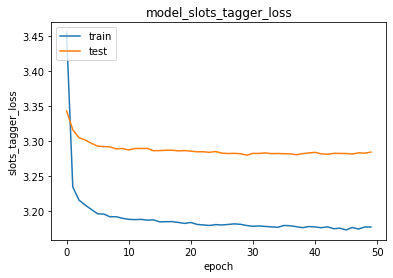

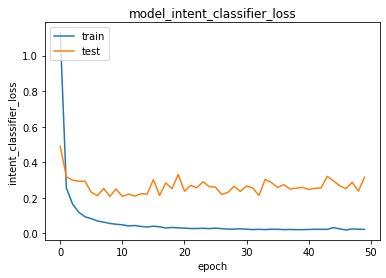

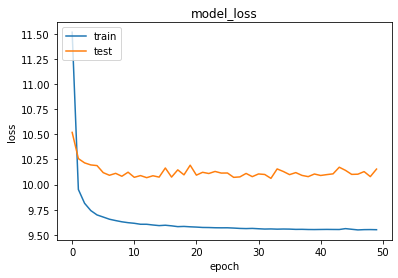

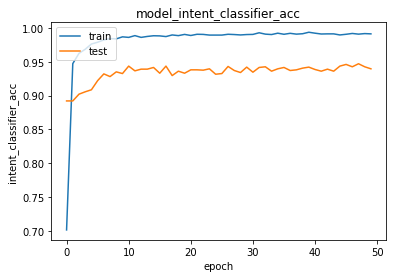

saving...
save_1


In [20]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import argparse
import tensorflow as tf
import pickle
import os

parser = argparse.ArgumentParser('Training the Joint Slot filling and Intent classification based on Bert')
parser.add_argument('--train', '-t', help='path to training data', type=str, required=True)
parser.add_argument('--val', '-v', help='path to validation data', type=str, required=True)
parser.add_argument('--save_1', '-s', help='folder path to save the trained model', type=str, required=True)
parser.add_argument('--epochs', '-e', help='number of epochs', type=int, default=5, required=False)
parser.add_argument('--batch_size', '-bs', help='batch size', type=int, default=64, required=False)

args = parser.parse_args('-t train -v val -s save_1'.split() )
train_data_folder_path =args.train
val_data_folder_path =args.val
save_folder_path =args.save_1
epochs =50
print(epochs)
batch_size =64

tf.compat.v1.random.set_random_seed(7)

sess = tf.compat.v1.Session()

bert_model_hub_path = 'https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1'

## import the dataset
# train_text_arr, train_tags_arr, train_intents = Reader.read('https://docs.google.com/spreadsheets/d/14XiTTUi2epnBUkIRwmygt7eFqUdKAK_2cFpKLVQZs2c/edit#gid=0') ## train dataset
# val_text_arr, val_tags_arr, val_intents = Reader2.read('https://docs.google.com/spreadsheets/d/14XiTTUi2epnBUkIRwmygt7eFqUdKAK_2cFpKLVQZs2c/edit#gid=0') ## validation dataset
print('\n')
print(train_tags_arr[0])
# vectorize the train_text_arr and val_text_arr
bert_vectorizer = BERTVectorizer(sess, bert_model_hub_path)
train_input_ids, train_input_mask, train_segment_ids, train_valid_positions, train_sequence_lengths = bert_vectorizer.transform(train_text_arr)
val_input_ids, val_input_mask, val_segment_ids, val_valid_positions, val_sequence_lengths = bert_vectorizer.transform(val_text_arr)
#print(train_input_ids, end="\n")
#print(train_input_mask,end="\n")
#print(train_segment_ids,end="\n")
print(train_valid_positions[0],end="\n")
#print(train_sequence_lengths,end="\n")
## vectorize the train_tags_arr and val_tags_arr
print(train_tags_arr[0],val_tags_arr[0])
tags_vectorizer = TagsVectorizer()
tags_vectorizer.fit(train_tags_arr, val_tags_arr) ## use the train dataset to fit the tagsvectorizer
train_tags = tags_vectorizer.transform(train_tags_arr, train_valid_positions)
val_tags = tags_vectorizer.transform(val_tags_arr, val_valid_positions)
slots_num = len(tags_vectorizer.label_encoder.classes_)


## encode the intents label, directly by using the LabelEncoder library, which is provided by skeleran
intents_label_encoder = LabelEncoder()
### atis dataset is a little strange, because in val_dataset, there are tags and intents that don't exit in train_dataset
intents_label_encoder.fit(train_intents+val_intents)
train_intents = intents_label_encoder.transform(train_intents).astype(np.int32)

# ## we should use the train dataset to fit the label encoder and then return the encoded labels
#train_intents = intents_label_encoder.fit_transform(train_intents).astype(np.int32) ## fit_transform

val_intents = intents_label_encoder.transform(val_intents).astype(np.int32) ## transform
intents_num = len(intents_label_encoder.classes_)
#print(intents_num)

model = JointBertModel(slots_num, intents_num, sess, num_bert_fine_tune_layers=12)
model.fit([train_input_ids, train_input_mask, train_segment_ids, train_valid_positions], [train_tags, train_intents],validation_data=([val_input_ids, val_input_mask, val_segment_ids, val_valid_positions], [val_tags, val_intents]),epochs=epochs, batch_size=batch_size)

## saving
print('saving...')
print(save_folder_path)
if not os.path.exists(save_folder_path):
    os.makedirs(save_folder_path)
    print('Folder "%s" created' % save_folder_path)
model.save(save_folder_path)

with open(os.path.join(save_folder_path, 'tags_vectorizer.pkl'), 'wb') as handle:
    pickle.dump(tags_vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.path.join(save_folder_path, 'intents_label_encoder.pkl'), 'wb') as handle:
    pickle.dump(intents_label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

tf.compat.v1.reset_default_graph()

In [21]:
if not os.path.exists('/content/drive/My Drive/NLU_MODEl_with_privious_itent'):
    os.makedirs('/content/drive/My Drive/NLU_MODEl_with_privious_itent')
    print('Folder "%s" created' % save_folder_path)
model.save('/content/drive/My Drive/NLU_MODEl_with_privious_itent')

with open(os.path.join('/content/drive/My Drive/NLU_MODEl_with_privious_itent', 'tags_vectorizer.pkl'), 'wb') as handle:
    pickle.dump(tags_vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.path.join('/content/drive/My Drive/NLU_MODEl_with_privious_itent', 'intents_label_encoder.pkl'), 'wb') as handle:
    pickle.dump(intents_label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
print(train_input_ids.shape, train_input_mask.shape, train_segment_ids.shape, train_valid_positions.shape, train_sequence_lengths)

(5000, 50) (5000, 50) (5000, 50) (5000, 50) [13 21 13 ... 14 13 12]


# New Section

In [23]:
print(train_text_arr[0])
print()

hi, can you help me in buying a phone ?



In [24]:
print(train_input_ids[0])

[ 101 7632 1010 2064 2017 2393 2033 1999 9343 1037 3042 1029  102    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [24]:
print(train_input_mask[0])

[1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [25]:
data_text_arr=[]
data_tags_arr=[]
data_intents=[]
data_value=[]
for i in range(7000,8357):
  data_text_arr.append(text_arr_new[i])
  data_tags_arr.append(tag_arr_new2[i])
  data_intents.append(label_arr_new[i])
  
print(len(data_text_arr),len(data_tags_arr),len(data_intents))

1357 1357 1357


In [26]:
from itertools import chain
import argparse
import os
import pickle
from sklearn import metrics
import json

parser = argparse.ArgumentParser('Evaluating the Joint BERT model')
parser.add_argument('--model', '-m', help='path to joint bert model', type=str, required=True)
parser.add_argument('--data', '-d', help='path to test data', type=str, required=True)
parser.add_argument('--batch', '-bs', help='batch size', type=int, default=128, required=False)
parser.add_argument('--pre_intents', '-pre_is', help='teh file name of saving predicted intents', type=str, required=True)
parser.add_argument('--pre_slots', '-pre_sls', help='the file name of saving predicted slots/tags', type=str, required=True)

args = parser.parse_args('-m model -d data -pre_is pre_intents -pre_sls pre_slots'.split())
load_folder_path = args.model
data_folder_path = args.data
batch_size =64
pre_intens_name = args.pre_intents
pre_slots_name = args.pre_slots

sess = tf.compat.v1.Session()

bert_model_hub_path = 'https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1'
bert_vectorizer = BERTVectorizer(sess, bert_model_hub_path)

## loading the model
print('Loading models ....')
if not os.path.exists('/content/drive/My Drive/NLU_MODEl_with_privious_itent'):
    print('Folder "%s" not exist' % load_folder_path)

with open(os.path.join('/content/drive/My Drive/NLU_MODEl_with_privious_itent', 'tags_vectorizer.pkl'), 'rb') as handle:
    tags_vectorizer = pickle.load(handle)
    slots_num = len(tags_vectorizer.label_encoder.classes_)
with open(os.path.join('/content/drive/My Drive/NLU_MODEl_with_privious_itent', 'intents_label_encoder.pkl'), 'rb') as handle:
    intents_label_encoder = pickle.load(handle)
    intents_num = len(intents_label_encoder.classes_)
print(tags_vectorizer)
model = JointBertModel.load('/content/drive/My Drive/NLU_MODEl_with_privious_itent', sess)

#data_text_arr, data_tags_arr, data_intents = Reader2.read('https://docs.google.com/spreadsheets/d/14XiTTUi2epnBUkIRwmygt7eFqUdKAK_2cFpKLVQZs2c/edit#gid=0')
data_input_ids, data_input_mask, data_segment_ids, data_valid_positions, data_sequence_lengths = bert_vectorizer.transform(data_text_arr)
print(data_input_ids,data_input_mask)

def flatten(y):
    ## flatten a list of lists.
    ## flatten([[1,2], [3,4]]) --> [1, 2, 3, 4]
    return list(chain.from_iterable(y))

def get_results(input_ids, input_mask, segment_ids, valid_positions, sequence_lengths, tags_arr, intents, tags_vectorizer, intents_label_encoder):
    predicted_tags, predicted_intents = model.predict_slots_intent(
        [input_ids, input_mask, segment_ids, valid_positions],
        tags_vectorizer, intents_label_encoder, remove_start_end=True
    )
    real_tags = [x.split() for x in tags_arr]
    #real_tags2=real_tags+real_tags[1][1]
    #predicted_tags=predicted_tags[:-1]
    #predicted_tags = [x.split() for x in predicted_tags]
    #predicted_tags=predicted_tags[:-1]
    f1_score = metrics.f1_score(flatten(real_tags), flatten(predicted_tags), average='micro')
    acc = metrics.accuracy_score(intents, predicted_intents)
    return f1_score ,acc, predicted_intents, predicted_tags
print('.....Evaluation....')
#print(shape(data_input_ids))
f1_score,acc, predicted_intents, predicted_tags = get_results(data_input_ids, data_input_mask, data_segment_ids, data_valid_positions, data_sequence_lengths,data_tags_arr, data_intents,  tags_vectorizer,
                                                               intents_label_encoder)

print(acc)
print(predicted_intents)
print(len(predicted_tags))
print(predicted_tags)
### print(type(predicted_tags)) ## <class 'numpy.ndarray'>
### save the predicted slots to file
# with open(os.path.join('/content/save_1', pre_slots_name), 'w') as fp:
#     for item in predicted_tags:
#         #print(item)
#         fp.write(" ".join(item) + "\n")
#     fp.close()

### print(type(predicted_intents)) ## <class 'numpy.ndarray'>
### save the predicted intents to file
# with open(os.path.join('/content/save_1', pre_intens_name), 'w') as fp:
#     for item in predicted_intents:
#         #print(item)
#         fp.write("".join(map(str, item)))
#     fp.close()

print('Slot f1 score = %f' % f1_score)
print('Intent accuracy = %f' % acc)


### save the f1 score and accuracy to file
eva_results = {
    "slots_f1_score" : f1_score,
    "intent_accuracy" : acc
}
with open(os.path.join('/content/drive/My Drive/NLU_MODEl_with_privious_itent', "eva_results.json"), 'w') as json_file:
    json.dump(eva_results, json_file)

tf.compat.v1.reset_default_graph()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Loading models ....
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
valid_positions (InputLayer)    [(None, None, 61)]   0                                            
______________________________________________________________________________________________

In [27]:
cc=0
dd=0
real_tags=[x.split() for x in data_tags_arr]
for i in range(len(real_tags)):
  c=0
  length=len(real_tags[i])
  for j in range(len(real_tags[i])):
    if j<len(predicted_tags[i]):
      if real_tags[i][j]==predicted_tags[i][j]:
        c=c+1
  if c==length:
    print(real_tags[i],predicted_tags[i])
    cc=cc+1
  else:
    dd=dd+1




['O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'B-Released_Yr', 'O', 'O', 'B-Color', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'B-Released_Yr', 'O', 'O', 'B-Color', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'B-Brand', 'O', 'O', 'B-Battery', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'B-Brand', 'O', 'O', 'B-Battery', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 

In [28]:
print(cc/len(real_tags))

0.8865143699336773


In [28]:
print(cc)

1190


In [29]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
print ('Confusion Matrix :')
results = confusion_matrix(data_intents, predicted_intents) 
print(results) 
print ('Accuracy Score :',accuracy_score(data_intents, predicted_intents) )
print ('Report : ')
print (classification_report(data_intents, predicted_intents) )

Confusion Matrix :
[[159   0   0   1   0   0   0   0   0   0   0   0   0]
 [  1  66   0   0   0   0   0   0   0  16   0   0   0]
 [  0   0   2   0   0   0   0   0   0   1   0   0   0]
 [  0   0   0 100   0   0   0   0   0   1   0  10   0]
 [  3   0   0   4 156   0   0   0   0   1   0   0   0]
 [  0   0   0   0   2   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  13   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 155   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0 320   1   5   0]
 [  0   0   0   0   0   0   0   0   0   2   0   0   0]
 [  0   1   0   1   0   0   0   0   0   1   0 330   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1   1]]
Accuracy Score : 0.9602063375092115
Report : 
                     precision    recall  f1-score   support

        Booking_Req       0.98      0.99      0.98       160
            Confirm       0.99      0.80      0.88        83
          Confirm_Q       1.00     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
print(data_input_ids.shape, data_input_mask.shape, data_segment_ids.shape, data_valid_positions.shape, data_sequence_lengths,data_tags_arr, data_intents)

(1357, 50) (1357, 50) (1357, 50) (1357, 50) [12 15 23 ... 12 22 11] [' O O O O O O', ' O O O O O O O O O O O O O', 'O O O O B-Released_Yr O O B-Color O O O', ' O O O O O O O', ' O O O O O', ' O O O O O O', ' O O O O O O O O', 'O O B-Radio O O O O', ' O O O O O O O O O O O', ' O O O O O', ' O O O O O O O O O O O O O', 'O O O O B-Brand O O B-Battery O O O', ' O O O O O O', ' O O O O O O O O', ' O O O O O O O O O', ' O O O O O O O O O O O', ' O O O O O O', ' O O O O O O O O O O O', 'O O O B-Color O O B-Brand O O O', ' O O O O O', 'O O B-Radio O O O O', ' O O O O O O', 'O O O O B-OS O O', ' O O O O O O O O O O O O O O', ' O O O O O O O O', ' O O O O O O', ' O O O O O O O O O O O O O', 'O O O O O O B-Sim O B-Radio O O O O O', ' O O O O O', ' O O O O O O', ' O O O O O O O O O O', ' O O O O O O O O O O O', ' O O O O O O', ' O O O O O O O O O O O O O O O O', 'O O O O O B-Cost O O O O', ' O O O O O', ' O O O O O O O', 'O O B-Battery O O O', ' O O O O O O O O', ' O O O O O O O O O O', 'O O O O B

In [31]:
# data_text_arr=np.array(data_text_arr)
# predicted_value=[]
# for i in range(len(predicted_tags)):
#   count=0
#   for j in range(len(predicted_tags[i])):
#     if predicted_tags[i][j]!='O':
#       count=count+1
#   if count==0:
#     predicted_value.append('null')
#   else:
#     for j in range(len(predicted_tags[i])):
#       text3=data_text_arr[i].split(' ')
#       text=""
#       if predicted_tags[i][j]!='O':
#         if text=="":

#           text2=text3[j-1]
#           text=text+text2
#         else:
#           text=text+","
#           text2=text3[j-1]
#           text=text+text2
#     print(text)
#     predicted_value.append(text)



In [ ]:
print(data_text_arr[1])
print(predicted_intents[1])
print(data_tags_arr[1])
print(data_intents[1])
print(predicted_tags[1])
print(data_input_ids[1], data_input_mask[1], data_segment_ids[1], data_valid_positions[1], data_sequence_lengths[1],sep="\n")

Hello , can you help me in selecting a phone ? Gratitude Welcome
Phn_SelReq
 O O O O O O O O O O O O O
Phn_SelReq
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[  101  7592  1010  2064  2017  2393  2033  1999 17739  1037  3042  1029
 15531  6160   102     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
15


In [ ]:
list1=[]
for i in range(25):
  print("........real.......")
  print(data_text_arr[i])
  print(data_intents[i])
  print(data_tags_arr[i])
  print(data_value[i])
  print("....predicted.....")
  print(predicted_intents[i])
  print(predicted_tags[i])
  count1=0
  data1=''
  for j in range(len(predicted_tags[i])):
    count=0
    
    if predicted_tags[i][j]!='O':
      data2=data_text_arr[i].split(' ')
      print(data2[j],end=',')
      if data1=='':
        data1=data1+data2[j]
      else:
        data1=data1+","
        data1=data1+data2[j]
      count1=1
    else:
      count=count+1
  if count!=0 and count1==0:
    print("null")
    list1.append("null")
  else:
    list1.append(data1)

        
  print('-------------------------')

........real.......
Thanks for helping me.
Gratitude
 O O O O
null
....predicted.....
Gratitude
['O', 'O', 'O', 'O']
null
-------------------------
........real.......
Hello , can you help me in selecting a phone ?
Phn_SelReq
 O O O O O O O O O O O
null
....predicted.....
Phn_SelReq
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
null
-------------------------
........real.......
Yes, i need a latest phone in grey color.
Slt_Info
O O O O B-Released_Yr O O B-Color O
Latest,Grey
....predicted.....
Slt_Info
['O', 'O', 'O', 'O', 'B-Released_Yr', 'O', 'O', 'B-Color', 'O']
latest,grey,-------------------------
........real.......
I want good battery back-up.
Query_Slot
 O O O O O
null
....predicted.....
Slt_Info
['O', 'O', 'B-Battery', 'O', 'O']
good,-------------------------
........real.......
how much ?
Query_Slot
 O O O
null
....predicted.....
Query_Slot
['O', 'O', 'O']
null
-------------------------
........real.......
whats it's display size?
Query_Slot
 O O O O
null
....predic

In [ ]:
list1=[]
for i in range(len(predicted_tags)):
  # print("........real.......")
  # print(data_text_arr[i])
  # print(data_intents[i])
  # print(data_tags_arr[i])
  # print(data_value[i])
  # print("....predicted.....")
  # print(predicted_intents[i])
  # print(predicted_tags[i])
  count1=0
  data1=''
  for j in range(len(predicted_tags[i])):
    count=0
    
    if predicted_tags[i][j]!='O':
      data2=data_text_arr[i].split(' ')
      #print(data2[j],end=',')
      if data1=='':
        data1=data1+data2[j]
      else:
        data1=data1+","
        data1=data1+data2[j]
      count1=1
    else:
      count=count+1
  if count!=0 and count1==0:
    #print("null")
    list1.append("null")
  else:
    list1.append(data1)

        
  #print('-------------------------')

In [ ]:
print(len(list1))

1357


In [ ]:
count=0
for i in range(len(data_value)):
  if data_value[i].lower()==list1[i].lower():
    count=count+1
print(count/len(data_value))

0.7980840088430361


In [ ]:
for i in range(100):
  print("real : "+data_tags_arr[i],sep='\n')
  print(predicted_tags[i],sep='\n\n')

real :  O O O O
['O', 'O', 'O', 'O']
real :  O O O O O O O O O O O
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
real : O O O O B-Released_Yr O O B-Color O
['O', 'O', 'O', 'O', 'B-Released_Yr', 'O', 'O', 'B-Color', 'O']
real :  O O O O O
['O', 'O', 'B-Battery', 'O', 'O']
real :  O O O
['O', 'O', 'O']
real :  O O O O
['O', 'O', 'O', 'O']
real :  O O O O O O
['O', 'O', 'O', 'O', 'O', 'O']
real : O O B-Radio O O
['O', 'O', 'O', 'O', 'O']
real :  O O O O O O O O O
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
real :  O O O
['O', 'O', 'O']
real :  O O O O O O O O O O O
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
real : O O O O B-Brand O O B-Battery O
['O', 'O', 'O', 'O', 'B-Brand', 'O', 'O', 'B-Battery', 'O']
real :  O O O O
['O', 'O', 'O', 'O']
real :  O O O O O O
['O', 'O', 'O', 'O', 'O', 'O']
real :  O O O O O O O
['O', 'O', 'O', 'O', 'O', 'O', 'O']
real :  O O O O O O O O O
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
real :  O O O O
['O', 'O', 'O', 'O']
real :  O

In [ ]:
for i in range(100):
  print("real : "+data_intents[i],sep='\n')
  print(predicted_intents[i],sep='\n\n')

real : Gratitude
Gratitude
real : Phn_SelReq
Phn_SelReq
real : Slt_Info
Slt_Info
real : Query_Slot
Slt_Info
real : Query_Slot
Query_Slot
real : Query_Slot
Query_Slot
real : Feedback
Feedback
real : Confirm
Query_Slot
real : Booking_Req
Booking_Req
real : Gratitude
Gratitude
real : Phn_SelReq
Phn_SelReq
real : Slt_Info
Slt_Info
real : Query_Slot
Query_Slot
real : Query_Slot
Query_Slot
real : Feedback
Feedback
real : Booking_Req
Booking_Req
real : Gratitude
Gratitude
real : Phn_SelReq
Phn_SelReq
real : Slt_Info
Slt_Info
real : Query_Slot
Query_Slot
real : Confirm
Query_Slot
real : Query_Slot
Query_Slot
real : Slt_Info
Slt_Info
real : Feedback
Feedback
real : Booking_Req
Booking_Req
real : Gratitude
Gratitude
real : Phn_SelReq
Phn_SelReq
real : Slt_Info
Slt_Info
real : Query_Slot
Query_Slot
real : Query_Slot
Slt_Info
real : Feedback
Slt_Info
real : Booking_Req
Booking_Req
real : Gratitude
Gratitude
real : Phn_SelReq
Phn_SelReq
real : Slt_Info
Slt_Info
real : Query_Slot
Query_Slot
real : Q

In [31]:
data_text_arr=[]
data_tags_arr=[]
data_intents=[]
data_value=[]
for i in range(0,5000):
  data_text_arr.append(text_arr_new[i])
  data_tags_arr.append(tag_arr_new2[i])
  data_intents.append(label_arr_new[i])
  #data_value.append(tag_value_new[i])
print(len(data_text_arr),len(data_tags_arr),len(data_intents))

5000 5000 5000


In [32]:
from itertools import chain
import argparse
import os
import pickle
from sklearn import metrics
import json

parser = argparse.ArgumentParser('Evaluating the Joint BERT model')
parser.add_argument('--model', '-m', help='path to joint bert model', type=str, required=True)
parser.add_argument('--data', '-d', help='path to test data', type=str, required=True)
parser.add_argument('--batch', '-bs', help='batch size', type=int, default=128, required=False)
parser.add_argument('--pre_intents', '-pre_is', help='teh file name of saving predicted intents', type=str, required=True)
parser.add_argument('--pre_slots', '-pre_sls', help='the file name of saving predicted slots/tags', type=str, required=True)

args = parser.parse_args('-m model -d data -pre_is pre_intents -pre_sls pre_slots'.split())
load_folder_path = args.model
data_folder_path = args.data
batch_size =64
pre_intens_name = args.pre_intents
pre_slots_name = args.pre_slots

sess = tf.compat.v1.Session()

bert_model_hub_path = 'https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1'
bert_vectorizer = BERTVectorizer(sess, bert_model_hub_path)

## loading the model
print('Loading models ....')
if not os.path.exists('/content/drive/My Drive/NLU_MODEl_with_privious_itent'):
    print('Folder "%s" not exist' % load_folder_path)

with open(os.path.join('/content/drive/My Drive/NLU_MODEl_with_privious_itent', 'tags_vectorizer.pkl'), 'rb') as handle:
    tags_vectorizer = pickle.load(handle)
    slots_num = len(tags_vectorizer.label_encoder.classes_)
with open(os.path.join('/content/drive/My Drive/NLU_MODEl_with_privious_itent', 'intents_label_encoder.pkl'), 'rb') as handle:
    intents_label_encoder = pickle.load(handle)
    intents_num = len(intents_label_encoder.classes_)
print(tags_vectorizer)
model = JointBertModel.load('/content/drive/My Drive/NLU_MODEl_with_privious_itent', sess)

#data_text_arr, data_tags_arr, data_intents = Reader2.read('https://docs.google.com/spreadsheets/d/14XiTTUi2epnBUkIRwmygt7eFqUdKAK_2cFpKLVQZs2c/edit#gid=0')
data_input_ids, data_input_mask, data_segment_ids, data_valid_positions, data_sequence_lengths = bert_vectorizer.transform(data_text_arr)
#print(data_input_ids,data_input_mask)

def flatten(y):
    ## flatten a list of lists.
    ## flatten([[1,2], [3,4]]) --> [1, 2, 3, 4]
    return list(chain.from_iterable(y))

def get_results(input_ids, input_mask, segment_ids, valid_positions, sequence_lengths, tags_arr, intents, tags_vectorizer, intents_label_encoder):
    predicted_tags, predicted_intents = model.predict_slots_intent(
        [input_ids, input_mask, segment_ids, valid_positions],
        tags_vectorizer, intents_label_encoder, remove_start_end=True
    )
    real_tags = [x.split() for x in tags_arr]
    #real_tags2=real_tags[:-25]
    f1_score = metrics.f1_score(flatten(real_tags), flatten(predicted_tags), average='micro')
    acc = metrics.accuracy_score(intents, predicted_intents)
    return f1_score, acc, predicted_intents, predicted_tags
print('.....Evaluation....')
#print(shape(data_input_ids))
f1_score,acc, predicted_intents, predicted_tags = get_results(data_input_ids, data_input_mask, data_segment_ids, data_valid_positions, data_sequence_lengths,data_tags_arr, data_intents,  tags_vectorizer,
                                                               intents_label_encoder)

print(acc)
print(predicted_intents)
print(len(predicted_tags))
print(predicted_tags)


tf.compat.v1.reset_default_graph()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Loading models ....
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
valid_positions (InputLayer)    [(None, None, 61)]   0                                            
______________________________________________________________________________________________

In [33]:
print(f1_score)

0.9972966069223892


In [34]:
cc=0
dd=0
real_tags=[x.split() for x in data_tags_arr]
for i in range(len(real_tags)):
  c=0
  length=len(real_tags[i])
  for j in range(len(real_tags[i])):
    if j<len(predicted_tags[i]):
      if real_tags[i][j]==predicted_tags[i][j]:
        c=c+1
  if c==length:
    print(real_tags[i],predicted_tags[i])
    cc=cc+1
  else:
    dd=dd+1




['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'B-Camera', 'O', 'O', 'B-Battery', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'B-Camera', 'O', 'O', 'B-Battery', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'B-Color', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'B-Color', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O'] 

In [35]:
print(cc/len(real_tags))

0.9792


In [36]:
print(cc)

4896


In [37]:
list1=[]
for i in range(25):
  print("........real.......")
  print(data_text_arr[i])
  print(data_intents[i])
  print(data_tags_arr[i])
  print(data_value[i])
  print("....predicted.....")
  print(predicted_intents[i])
  print(predicted_tags[i])
  count1=0
  data1=''
  for j in range(len(predicted_tags[i])):
    count=0
    
    if predicted_tags[i][j]!='O':
      data2=data_text_arr[i].split(' ')
      print(data2[j],end=',')
      if data1=='':
        data1=data1+data2[j]
      else:
        data1=data1+","
        data1=data1+data2[j]
      count1=1
    else:
      count=count+1
  if count!=0 and count1==0:
    print("null")
    list1.append("null")
  else:
    list1.append(data1)

        
  print('-------------------------')

........real.......
hi, can you help me in buying a phone ?
Phn_SelReq
O O O O O O O O O O


IndexError: ignored

In [ ]:
list1=[]
for i in range(len(data_tags_arr)):
  # print("........real.......")
  # print(data_text_arr[i])
  # print(data_intents[i])
  # print(data_tags_arr[i])
  # print(data_value[i])
  # print("....predicted.....")
  # print(predicted_intents[i])
  # print(predicted_tags[i])
  count1=0
  data1=''
  for j in range(len(predicted_tags[i])):
    count=0
    
    if predicted_tags[i][j]!='O':
      data2=data_text_arr[i].split(' ')
      #print(data2[j],end=',')
      if data1=='':
        data1=data1+data2[j]
      else:
        data1=data1+","
        data1=data1+data2[j]
      count1=1
    else:
      count=count+1
  if count!=0 and count1==0:
    #print("null")
    list1.append("null")
  else:
    list1.append(data1)

        
  #print('-------------------------')

In [ ]:
print(len(list1))

5000


In [ ]:
count=0
for i in range(len(data_value)):
  if data_value[i].lower()==list1[i].lower():
    count=count+1
print(count/len(data_value))

0.8318


In [ ]:
for i in range(20):
  print('real : ',data_value[i])
  print('predicted : ',list1[i])
  print('----------------------')

real :  null
predicted :  null
----------------------
real :  High,High
predicted :  good,good
----------------------
real :  null
predicted :  null
----------------------
real :  null
predicted :  null
----------------------
real :  Black
predicted :  black
----------------------
real :  null
predicted :  null
----------------------
real :  null
predicted :  null
----------------------
real :  null
predicted :  null
----------------------
real :  null
predicted :  null
----------------------
real :  null
predicted :  null
----------------------
real :  Android,Y
predicted :  android,dual
----------------------
real :  null
predicted :  null
----------------------
real :  null
predicted :  null
----------------------
real :  White
predicted :  white
----------------------
real :  null
predicted :  null
----------------------
real :  null
predicted :  null
----------------------
real :  null
predicted :  null
----------------------
real :  null
predicted :  null
----------------------
r

In [29]:
data_text_arr=[]
data_tags_arr=[]
data_intents=[]
data_value=[]
for i in range(5000,7000):
  data_text_arr.append(text_arr_new[i])
  data_tags_arr.append(tag_arr_new2[i])
  data_intents.append(label_arr_new[i])
  #data_value.append(tag_value_new[i])
print(len(data_text_arr),len(data_tags_arr),len(data_intents))

2000 2000 2000


In [ ]:
from itertools import chain
import argparse
import os
import pickle
from sklearn import metrics
import json

parser = argparse.ArgumentParser('Evaluating the Joint BERT model')
parser.add_argument('--model', '-m', help='path to joint bert model', type=str, required=True)
parser.add_argument('--data', '-d', help='path to test data', type=str, required=True)
parser.add_argument('--batch', '-bs', help='batch size', type=int, default=128, required=False)
parser.add_argument('--pre_intents', '-pre_is', help='teh file name of saving predicted intents', type=str, required=True)
parser.add_argument('--pre_slots', '-pre_sls', help='the file name of saving predicted slots/tags', type=str, required=True)

args = parser.parse_args('-m model -d data -pre_is pre_intents -pre_sls pre_slots'.split())
load_folder_path = args.model
data_folder_path = args.data
batch_size =64
pre_intens_name = args.pre_intents
pre_slots_name = args.pre_slots

sess = tf.compat.v1.Session()

bert_model_hub_path = 'https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1'
bert_vectorizer = BERTVectorizer(sess, bert_model_hub_path)

## loading the model
print('Loading models ....')
if not os.path.exists('/content/drive/My Drive/NLU_MODEl_with_privious_itent'):
    print('Folder "%s" not exist' % load_folder_path)

with open(os.path.join('/content/drive/My Drive/NLU_MODEl_with_privious_itent', 'tags_vectorizer.pkl'), 'rb') as handle:
    tags_vectorizer = pickle.load(handle)
    slots_num = len(tags_vectorizer.label_encoder.classes_)
with open(os.path.join('/content/drive/My Drive/NLU_MODEl_with_privious_itent', 'intents_label_encoder.pkl'), 'rb') as handle:
    intents_label_encoder = pickle.load(handle)
    intents_num = len(intents_label_encoder.classes_)
print(tags_vectorizer)
model = JointBertModel.load('/content/drive/My Drive/NLU_MODEl_with_privious_itent', sess)

#data_text_arr, data_tags_arr, data_intents = Reader2.read('https://docs.google.com/spreadsheets/d/14XiTTUi2epnBUkIRwmygt7eFqUdKAK_2cFpKLVQZs2c/edit#gid=0')
data_input_ids, data_input_mask, data_segment_ids, data_valid_positions, data_sequence_lengths = bert_vectorizer.transform(data_text_arr)
#print(data_input_ids,data_input_mask)

def flatten(y):
    ## flatten a list of lists.
    ## flatten([[1,2], [3,4]]) --> [1, 2, 3, 4]
    return list(chain.from_iterable(y))

def get_results(input_ids, input_mask, segment_ids, valid_positions, sequence_lengths, tags_arr, intents, tags_vectorizer, intents_label_encoder):
    predicted_tags, predicted_intents = model.predict_slots_intent(
        [input_ids, input_mask, segment_ids, valid_positions],
        tags_vectorizer, intents_label_encoder, remove_start_end=True
    )
    real_tags = [x.split() for x in tags_arr]
    #real_tags2=real_tags[:-25]
    f1_score = metrics.f1_score(flatten(real_tags), flatten(predicted_tags), average='micro')
    acc = metrics.accuracy_score(intents, predicted_intents)
    return  f1_score,acc, predicted_intents, predicted_tags
print('.....Evaluation....')
#print(shape(data_input_ids))
f1_score,acc, predicted_intents, predicted_tags = get_results(data_input_ids, data_input_mask, data_segment_ids, data_valid_positions, data_sequence_lengths,data_tags_arr, data_intents,  tags_vectorizer,
                                                               intents_label_encoder)

print(acc)
print(predicted_intents)
print(len(predicted_tags))
print(predicted_tags)
print('f1_score :',f1_score)

tf.compat.v1.reset_default_graph()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Loading models ....
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
valid_positions (InputLayer)    [(None, None, 61)]   0                                            
______________________________________________________________________________________________

In [32]:
cc=0
dd=0
real_tags=[x.split() for x in data_tags_arr]
for i in range(len(real_tags)):
  c=0
  length=len(real_tags[i])
  for j in range(len(real_tags[i])):
    if j<len(predicted_tags[i]):
      if real_tags[i][j]==predicted_tags[i][j]:
        c=c+1
  if c==length:
    print(real_tags[i],predicted_tags[i])
    cc=cc+1
  else:
    dd=dd+1




['O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'B-Sim', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'B-Sim', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'B-Brand', 'O', 'B-Cost', 'I-Cost', 'O', 'O', 'O'] ['O', 'O', 'B-Brand', 'O', 'B-Cost', 'I-Cost', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O'] ['O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'B-Battery', 'O', 'O', 'O', 'O'] ['

In [33]:
print(cc/len(real_tags))

0.8705


In [36]:
print(cc)

1740


In [ ]:
list1=[]
for i in range(25):
  print("........real.......")
  print(data_text_arr[i])
  print(data_intents[i])
  print(data_tags_arr[i])
  print(data_value[i])
  print("....predicted.....")
  print(predicted_intents[i])
  print(predicted_tags[i])
  count1=0
  data1=''
  for j in range(len(predicted_tags[i])):
    count=0
    
    if predicted_tags[i][j]!='O':
      data2=data_text_arr[i].split(' ')
      print(data2[j],end=',')
      if data1=='':
        data1=data1+data2[j]
      else:
        data1=data1+","
        data1=data1+data2[j]
      count1=1
    else:
      count=count+1
  if count!=0 and count1==0:
    print("null")
    list1.append("null")
  else:
    list1.append(data1)

  print('\n')      
  print('-------------------------')

........real.......
Which OS it supports?
Query_Slot
 O O O O
null
....predicted.....
Query_Slot
['O', 'O', 'O', 'O']
null


-------------------------
........real.......
Does it have dual sim slot?
Slt_Info
O O O B-Sim O O
D
....predicted.....
Confirm
['O', 'O', 'O', 'B-Sim', 'O', 'O']
dual,

-------------------------
........real.......
I need dualsim phone only.
Feedback
 O O O O O
null
....predicted.....
Feedback
['O', 'O', 'O', 'O', 'O']
null


-------------------------
........real.......
Okay book this for me.
Booking_Req
 O O O O O
null
....predicted.....
Booking_Req
['O', 'O', 'O', 'O', 'O']
null


-------------------------
........real.......
Thanks for helping me.
Gratitude
 O O O O
null
....predicted.....
Gratitude
['O', 'O', 'O', 'O']
null


-------------------------
........real.......
Do you have good phone with you?
Phn_SelReq
 O O O O O O O
null
....predicted.....
Phn_SelReq
['O', 'O', 'O', 'O', 'O', 'O', 'O']
null


-------------------------
........real.......
I am l

In [ ]:
list1=[]
for i in range(len(predicted_tags)):
  # print("........real.......")
  # print(data_text_arr[i])
  # print(data_intents[i])
  # print(data_tags_arr[i])
  # print(data_value[i])
  # print("....predicted.....")
  # print(predicted_intents[i])
  # print(predicted_tags[i])
  count1=0
  data1=''
  s=np.array(predicted_tags[i])
  for j in range(len(s)):
    count=0
    
    if predicted_tags[i][j]!='O':
      data2=data_text_arr[i].split(' ')
      #print(data2[j],end=',')
      if data1=='':
        data1=data1+data2[j]
      else:
        data1=data1+","
        data1=data1+data2[j]
      count1=1
    else:
      count=count+1
  if count!=0 and count1==0:
    #print("null")
    list1.append("null")
  else:
    list1.append(data1)

        
  #print('-------------------------')

In [ ]:
count=0
for i in range(len(data_value)):
  if data_value[i].lower()==list1[i].lower():
    count=count+1
print(count/len(data_value))

0.7835


In [ ]:
list2=[]
for i in range(len(predicted_tags)):
  count1=0
  data1=''
  s=np.array(predicted_tags[i])
  for j in range(len(s)):
    count=0
    if predicted_tags[i][j]!='O':
      data2=data_text_arr[i].split(' ')
      #print(data2[j],end=',')
      if data1=='':
        if predicted_tags[i][j].split('-')[1]=='Radio' or predicted_tags[i][j].split('-')[1]=='GPS':
          d=data2[j]
          if(d=='radio'or d=='GPS'):
            data1=data1+'Y'
          else:
            data1=data1+data2[j]
        else:
          data1=data1+data2[j]
      else:
        if predicted_tags[i][j].split('-')[0]=='I':
          data1=data1+data2[j]
        else:
          data1=data1+","
          data1=data1+data2[j]
      count1=1
    else:
      count=count+1
  if count!=0 and count1==0:
    #print("null")
    list2.append("null")
  else:
    list2.append(data1)

        
  #print('-------------------------')

In [ ]:
count=0
for i in range(len(data_value)):
  if data_value[i].lower()==list2[i].lower():
    count=count+1
print(count/len(data_value))

0.7875
